# Q6. Implement the EM algorithm for Gaussian mixture models.

In [41]:
import numpy as np
from matplotlib import pyplot as plt
import time
import random

In [30]:
def MultiVarNormal(x,mean,cov):
    determinantCov = np.linalg.det(np.dot(2*np.pi,cov))
    inverseCov = np.linalg.inv(cov)
    gene_adjusted = x - mean
    exponent = np.matmul(np.matmul(gene_adjusted, inverseCov), gene_adjusted.transpose())
    scalar = exponent.item(0)
    prob =  np.power(determinantCov, -0.5)*(np.power(np.e, -0.5*scalar))
    return prob

In [31]:
def UpdateMixProps(hidden_matrix):
    updatedMixProps = []
    n = len(hidden_matrix)
    for i in range(len(hidden_matrix[0])):
        mixprop = 0
        for x in hidden_matrix:
            mixprop += x[i]   # P(c^n = i|x^n)
        updatedMixProps.append(mixprop/n)
    return np.array(updatedMixProps)

In [32]:
def UpdateMeans(X, hidden_matrix):
    updatedmeans = []
    for i in range(len(hidden_matrix[0])):
        mean_numerator = np.zeros(len(X[0]))
        mean_denominator = 0
        for n in range(len(X)):
            mean_numerator  = np.add(mean_numerator, np.dot(hidden_matrix[n][i], X[n]))
            mean_denominator += hidden_matrix[n][i]
        updatedmeans.append(np.dot(1/mean_denominator, mean_numerator))
    return np.array(updatedmeans)

In [33]:
def UpdateCovar(X, hidden_matrix, means, i):
    numerator = np.zeros((len(means[0]), len(means[0])))
    denominator = 0
    for n in range(len(X)): 
        product = np.matmul(np.array([X[n] - means[i]]).transpose(), np.array([X[n]-means[i]]))
        numerator += hidden_matrix[n][i]*product
        denominator += hidden_matrix[n][i]
    updatedCovar = numerator/denominator# dividing each entry of numerator (matrix) by the denominator (scalar)
    return updatedCovar

In [34]:
def UpdateCovars(X, hidden_matrix, means): # get 3 (2-D lists) --> covariance matrix (d,d) for each cluster (k = 3)
    new_Covs = []
    for i in range(len(means)):
        new_Covs.append(UpdateCovar(X, hidden_matrix, means, i))
    return np.array(new_Covs)


In [35]:
def HiddenMatrix(X, means, covs, mix_props):
    # hidden matrix
    hiddenMat = []
    for n in range(len(X)): # N
        hiddenMatRow = []
        denominator = 0
        for i in range(len(means)): # k         
            denominator += mix_props[i] * MultiVarNormal(X[n],means[i],covs[i])
        for i in range(len(means)):
            numerator = mix_props[i] * MultiVarNormal(X[n],means[i],covs[i])
            hiddenMatRow.append(numerator/denominator)
        hiddenMat.append(hiddenMatRow)

    # log likelihood 
    logLikelihood = 0
    for n in range(len(X)):
        summand = 0
        for j in range(len(means)):
            summand += mix_props[j] * MultiVarNormal(X[n],means[j],covs[j])
        logLikelihood += np.log(summand)
    
    return np.array(hiddenMat), logLikelihood

In [37]:
def GMM(X, init_means, init_covs, init_mix_props, thres=0.001):
    clusters = []
    log_likelihoods = [] # 2 element list, contains ll from current and the previous iteration 
    
    # E step
    h_mat, logLike = HiddenMatrix(X, init_means, init_covs, init_mix_props)
    log_likelihoods.append(logLike)
    
    # M step
    newMixProps = UpdateMixProps(h_mat)
    newMeans = UpdateMeans(X, h_mat)
    newCovars = UpdateCovars(X, h_mat, newMeans)
    
    # E step again
    h_mat, logLike = HiddenMatrix(X, newMeans, newCovars, newMixProps)
    log_likelihoods.append(logLike)

    while log_likelihoods[-1] - log_likelihoods[-2] >= thres:
        # M step again
        newMixProps = UpdateMixProps(h_mat)
        newMeans = UpdateMeans(X, h_mat)
        newCovars = UpdateCovars(X, h_mat, newMeans)
        # E step again
        h_mat, logLike = HiddenMatrix(X, newMeans, newCovars, newMixProps)
        log_likelihoods.append(logLike)
    
    for n in range(len(X)):
        prob = []
        # P(c = i | X_n) and assign X_n to the cluster (c = i) with the max P(c = i | X_n)
        for i in range(len(init_means)):
            prob.append(h_mat[n][i])
        clusters.append(prob.index(max(prob)))
    
    return clusters, log_likelihoods, h_mat


In [38]:
if __name__ == "__main__":
    data = np.loadtxt("data/mouse-data/hip1000.txt", dtype=np.float32,delimiter=',')
    test_means = np.loadtxt("data/test_mean.txt").T
    print('Data shape:',data.shape) # 208, 879
    print('test_means shape: ',test_means.shape) # 3, 208

    # initializations
    X = data[0:10].transpose()              # (879,10)                                 
    init_means = test_means[:, :10]         # (3, 10)
    init_mix_props = [0.3, 0.3, 0.4]
    init_cov = np.diag(np.ones(10), 0)      # (10, 10)
    lst = [init_cov, init_cov, init_cov]
    init_covs = np.array(lst)
    print("Running EM")
    clusters, ll, h_mat = GMM(X, init_means, init_covs, init_mix_props)
    print("Clusters: ", clusters)
    print("the log likelihood at the stopping condition: ", ll[-1])

Data shape: (208, 879)
test_means shape:  (3, 208)
Running EM
Clusters:  [2, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,

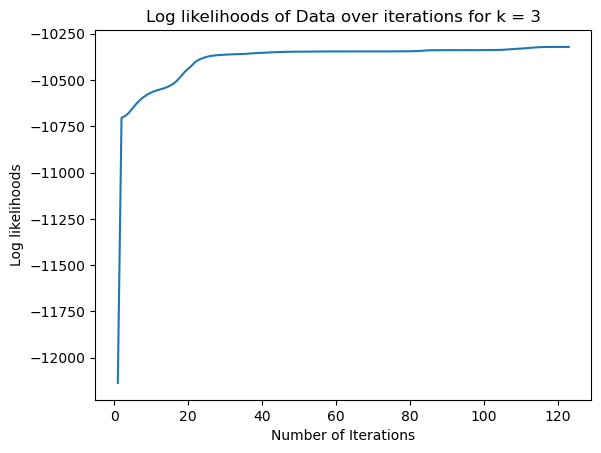

In [39]:
#Q6 a
y = ll
x = list(range(1, len(ll)+1))
plt.plot(x, y)
plt.xlabel("Number of Iterations")
plt.ylabel("Log likelihoods")
plt.title("Log likelihoods of Data over iterations for k = 3")
plt.show()

In [40]:
# Q6 b 
prob = []
for i in range(len(init_means)):
    prob.append(h_mat[0][i])
print("Probability of the first gene to belong to each of the three clusters: ", prob)


Probability of the first gene to belong to each of the three clusters:  [3.859495410304573e-05, 0.12508776644674802, 0.8748736385991489]


In [44]:
# Q6 c
def RandomParams(gmm_data, k, n_features, epsilon=0.005, eye_covar = False):
    means = gmm_data[np.random.choice(range(gmm_data.shape[0]),k, replace = False),:]
    if not eye_covar:
        covars = []
        for _ in range(k):
            covar = (np.eye(n_features,n_features)*np.random.sample())+np.random.normal(size=(n_features,n_features))
            covars += [covar.T.dot(covar)]
    else:
        covars = np.stack([np.diag(([1]*10))]*k)

    mix_props = np.random.sample(size=(k))
    mix_props = mix_props / np.sum(mix_props)

    return means, np.stack([x+np.eye(n_features,n_features)*epsilon for x in covars]), mix_props

In [47]:
all_loglikelihoods = []
data = np.loadtxt("data/mouse-data/hip1000.txt", dtype=np.float32,delimiter=',')
X = data[0:10].transpose()
for k in range(3, 11):
    init_means, init_covs, init_mix_props = RandomParams(X, k, 10, epsilon=0.005, eye_covar = False)
    c, ll, h_mat = GMM(X, init_means, init_covs, init_mix_props)
    all_loglikelihoods.append(ll[-1]) # all likelihoods for k = 3, ..., 10

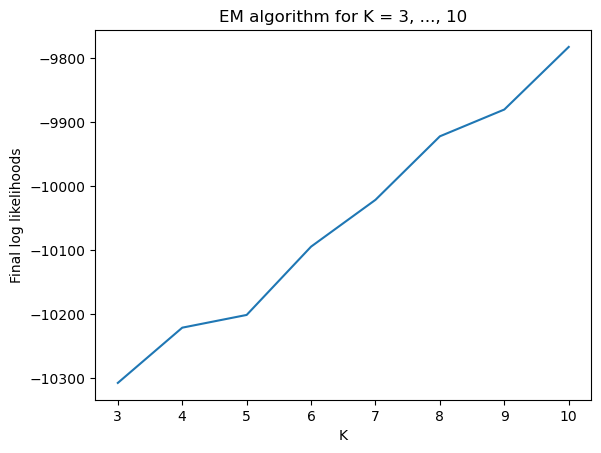

In [46]:
x = list(range(3,11))
#plt.scatter(x,all_loglikelihoods)
plt.plot(x,all_loglikelihoods)
plt.xlabel("K")
plt.ylabel("Final log likelihoods")
plt.title("EM algorithm for K = 3, ..., 10")
plt.show()